In [7]:
!pip install pandas
!pip install scikit-learn
!pip install gensim
!pip install numpy
!pip install matplotlib

In [8]:
# All the essential imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

In [9]:
# Set display options for pandas to avoid scientific notation
pd.set_option('display.float_format', lambda x: f'{int(x)}' if x == int(x) else f'{x:.0f}')

In [10]:
tweet_df_1 = pd.read_csv('/content/drive/MyDrive/Social Network Analysis & GNN/Traditional_ML/downloaded_tweets_extend_nolf2.tsv', sep='\t')
tweet_df_2 = pd.read_csv('/content/drive/MyDrive/Social Network Analysis & GNN/Traditional_ML/downloaded_tweets_extend_original_nolf2.tsv', sep='\t' )

In [11]:
#merging both the dataframe horizontally
merged_tweets = pd.concat([tweet_df_1, tweet_df_2], ignore_index=True).drop(columns=['public_metrics'])
merged_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106569 entries, 0 to 106568
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106567 non-null  object 
 1   author               106565 non-null  object 
 2   date                 106564 non-null  object 
 3   hashtags             85914 non-null   object 
 4   referenced           67598 non-null   object 
 5   in_reply_to_user_id  11094 non-null   float64
 6   text_nolf            83490 non-null   object 
dtypes: float64(1), object(6)
memory usage: 5.7+ MB


In [12]:
cleaned_df = merged_tweets.dropna(subset=['in_reply_to_user_id', 'referenced'])
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10877 entries, 3 to 106554
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10877 non-null  object 
 1   author               10877 non-null  object 
 2   date                 10877 non-null  object 
 3   hashtags             10868 non-null  object 
 4   referenced           10877 non-null  object 
 5   in_reply_to_user_id  10877 non-null  float64
 6   text_nolf            8546 non-null   object 
dtypes: float64(1), object(6)
memory usage: 679.8+ KB


In [13]:
# categorize author into high influence and low influence
# Authors with that recieved replies & quotes from more than 10 unique users will be considered as high influence
influence_counts = cleaned_df.groupby('author')['in_reply_to_user_id'].nunique()
influence_counts

,in_reply_to_user_id
author,
1688,3
673983,1
785406,1
813286,1
1652541,1
...,...
950215424981028864,7
967871677399994368,23
977710998,11


In [14]:
influence_threshold = 3
influence_counts = influence_counts.reset_index()
influence_counts['influence_category'] = influence_counts['in_reply_to_user_id'].apply(
    lambda x: 'high influence' if x > influence_threshold else 'low influence'
)
# change in_reply_to_user_id to user user count
influence_counts = influence_counts.rename(columns={'in_reply_to_user_id': 'users_replied_quoted'})

In [15]:
# Merge back with the original dataset if needed
cleaned_df_infl_label = pd.merge(
    cleaned_df,
    influence_counts[['author', 'influence_category']],
    on='author',
    how='inner'
)

In [16]:
cleaned_df_infl_label.drop_duplicates()

,id,author,date,hashtags,referenced,in_reply_to_user_id,text_nolf,influence_category
0,1520168272896962562,308045021,2022-04-29 22:28:54+00:00,"LC,exercise",[<ReferencedTweet id=1520168270283915264 type=...,308045021,Workouts &amp; ample sleep. Sigh….this is grea...,high influence
1,1518605841624190976,308045021,2022-04-25 15:00:21+00:00,"TakingABreak,exercise",[<ReferencedTweet id=1518605836607799296 type=...,308045021,Or will this be me by the end of the week? We’...,high influence
2,1516610008082960389,308045021,2022-04-20 02:49:37+00:00,authenticChineseFood,[<ReferencedTweet id=1516610006992535552 type=...,308045021,"Over cooked. As U can see from my picture, the...",high influence
3,1516601473219629056,308045021,2022-04-20 02:15:42+00:00,MyBigFatGreekWedding,[<ReferencedTweet id=1516408716442038272 type=...,42052422,@NiaVardalos You Persevered ..! #MyBigFatGreek...,high influence
4,1514433241545121793,308045021,2022-04-14 02:39:56+00:00,msm,[<ReferencedTweet id=1514332714379403283 type=...,16129920,"@maddow Texas local news, why aren’t u coverin...",high influence
...,...,...,...,...,...,...,...,...
10872,1520408831880179713,958685436112658432,2022-04-30 14:24:48+00:00,Albo4PM,[<ReferencedTweet id=1520369856071184384 type=...,1238370241169616896,NaN,low influence
10873,1520451336176902150,1170480176,2022-04-30 17:13:41+00:00,"DOG,ScienceResearch",[<ReferencedTweet id=1520450288095797251 type=...,1170480176,NaN,low influence
10874,1520454449583509505,791638976,2022-04-30 17:26:04+00:00,NeverVoteCon,[<ReferencedTweet id=1520452082632900610 type=...,25575859,NaN,low influence
10875,683703028621377537,93193090,2016-01-03 17:34:39+00:00,"ISIS,Ukraine,DonbRRRRRR,Donetsk,novorossia",[<ReferencedTweet id=683694522941964289 type=r...,93193090,NaN,low influence


In [17]:
#group by author based on influence category
cleaned_df_infl_label.groupby('influence_category')['author'].nunique()

,author
influence_category,
high influence,111
low influence,2494


In [18]:
cleaned_df_infl_label

,id,author,date,hashtags,referenced,in_reply_to_user_id,text_nolf,influence_category
0,1520168272896962562,308045021,2022-04-29 22:28:54+00:00,"LC,exercise",[<ReferencedTweet id=1520168270283915264 type=...,308045021,Workouts &amp; ample sleep. Sigh….this is grea...,high influence
1,1518605841624190976,308045021,2022-04-25 15:00:21+00:00,"TakingABreak,exercise",[<ReferencedTweet id=1518605836607799296 type=...,308045021,Or will this be me by the end of the week? We’...,high influence
2,1516610008082960389,308045021,2022-04-20 02:49:37+00:00,authenticChineseFood,[<ReferencedTweet id=1516610006992535552 type=...,308045021,"Over cooked. As U can see from my picture, the...",high influence
3,1516601473219629056,308045021,2022-04-20 02:15:42+00:00,MyBigFatGreekWedding,[<ReferencedTweet id=1516408716442038272 type=...,42052422,@NiaVardalos You Persevered ..! #MyBigFatGreek...,high influence
4,1514433241545121793,308045021,2022-04-14 02:39:56+00:00,msm,[<ReferencedTweet id=1514332714379403283 type=...,16129920,"@maddow Texas local news, why aren’t u coverin...",high influence
...,...,...,...,...,...,...,...,...
10872,1520408831880179713,958685436112658432,2022-04-30 14:24:48+00:00,Albo4PM,[<ReferencedTweet id=1520369856071184384 type=...,1238370241169616896,NaN,low influence
10873,1520451336176902150,1170480176,2022-04-30 17:13:41+00:00,"DOG,ScienceResearch",[<ReferencedTweet id=1520450288095797251 type=...,1170480176,NaN,low influence
10874,1520454449583509505,791638976,2022-04-30 17:26:04+00:00,NeverVoteCon,[<ReferencedTweet id=1520452082632900610 type=...,25575859,NaN,low influence
10875,683703028621377537,93193090,2016-01-03 17:34:39+00:00,"ISIS,Ukraine,DonbRRRRRR,Donetsk,novorossia",[<ReferencedTweet id=683694522941964289 type=r...,93193090,NaN,low influence


# High & Low Infl User Prediction Based on Text Data

Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8890
Logistic Regression Testing Accuracy: 0.8185
--------------------------------------------------------------------------------
Training Support Vector Machine...
Support Vector Machine Training Accuracy: 0.9606
Support Vector Machine Testing Accuracy: 0.8226
--------------------------------------------------------------------------------
Training Random Forest...
Random Forest Training Accuracy: 0.9647
Random Forest Testing Accuracy: 0.8111
--------------------------------------------------------------------------------
Training Gradient Boosting...
Gradient Boosting Training Accuracy: 0.6751
Gradient Boosting Testing Accuracy: 0.6558
--------------------------------------------------------------------------------
Training Naive Bayes...
Naive Bayes Training Accuracy: 0.7398
Naive Bayes Testing Accuracy: 0.6806
--------------------------------------------------------------------------------


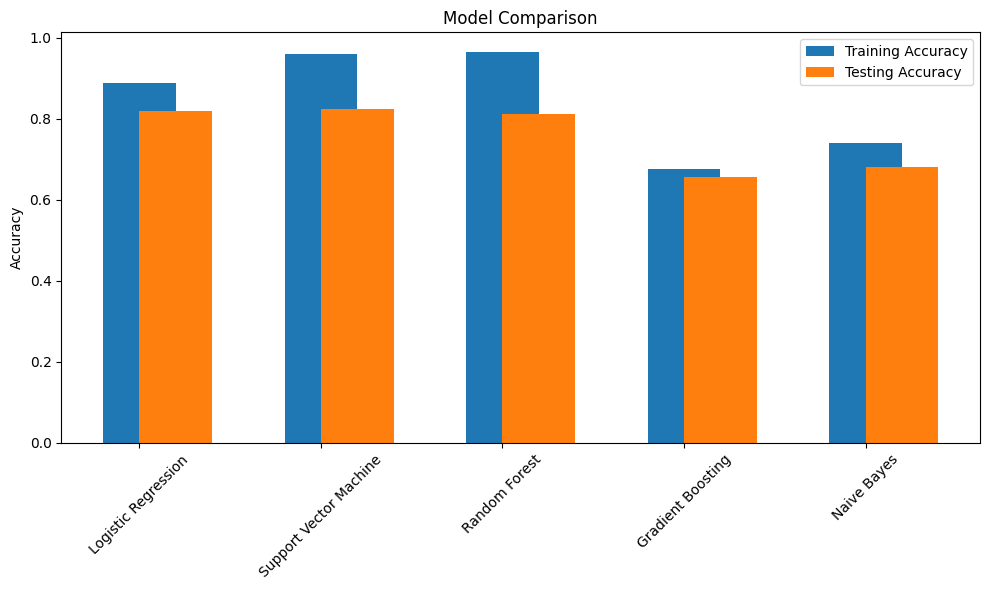

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

df = cleaned_df_infl_label
df['text_nolf'] = df['text_nolf'].fillna('')
label_encoder = LabelEncoder()
df['influence_label'] = label_encoder.fit_transform(df['influence_category'])

X = df['text_nolf']
y = df['influence_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

train_accuracies = {}
test_accuracies = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    train_accuracies[model_name] = train_acc
    test_accuracies[model_name] = test_acc

    print(f"{model_name} Training Accuracy: {train_acc:.4f}")
    print(f"{model_name} Testing Accuracy: {test_acc:.4f}")
    #print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))
    print("-" * 80)

plt.figure(figsize=(10,6))
model_names = list(models.keys())
train_acc_values = [train_accuracies[model] for model in model_names]
test_acc_values = [test_accuracies[model] for model in model_names]

x = range(len(models))

plt.bar(x, train_acc_values, width=0.4, label='Training Accuracy', align='center')
plt.bar(x, test_acc_values, width=0.4, label='Testing Accuracy', align='edge')
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.tight_layout()
plt.show()


# High & Low Infl User Prediction Based on Hashtags

Training Logistic Regression...
Logistic Regression Training Accuracy: 0.9007
Logistic Regression Testing Accuracy: 0.7845
--------------------------------------------------------------------------------
Training Support Vector Machine...
Support Vector Machine Training Accuracy: 0.9230
Support Vector Machine Testing Accuracy: 0.7886
--------------------------------------------------------------------------------
Training Random Forest...
Random Forest Training Accuracy: 0.9335
Random Forest Testing Accuracy: 0.7748
--------------------------------------------------------------------------------
Training Gradient Boosting...
Gradient Boosting Training Accuracy: 0.6966
Gradient Boosting Testing Accuracy: 0.6926
--------------------------------------------------------------------------------
Training Naive Bayes...
Naive Bayes Training Accuracy: 0.8985
Naive Bayes Testing Accuracy: 0.7854
--------------------------------------------------------------------------------


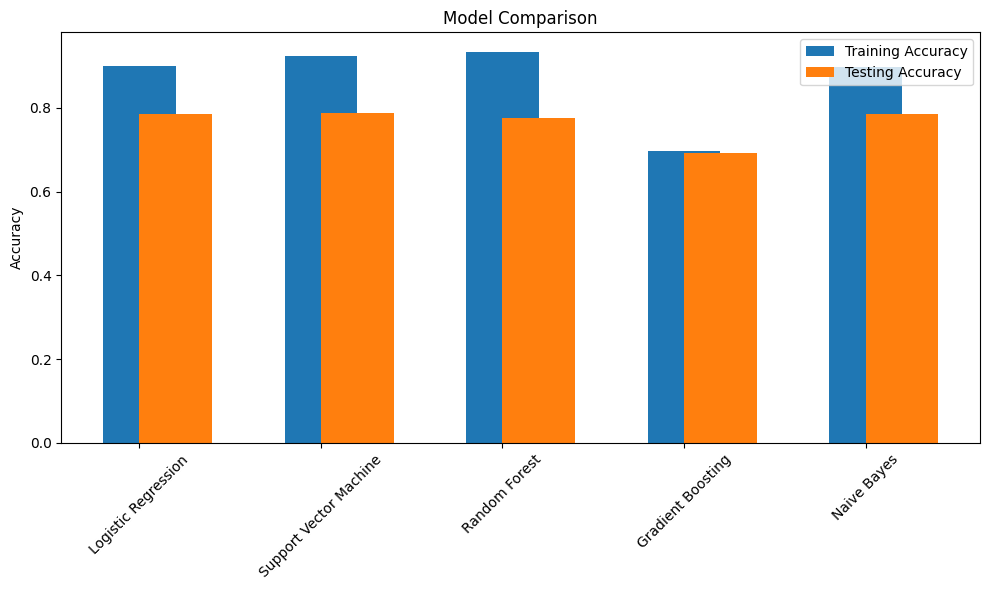

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

# Assuming 'cleaned_df_infl_label' is your DataFrame
df = cleaned_df_infl_label

# Fill NaN in 'hashtags' with empty string
df['hashtags'] = df['hashtags'].fillna('')

# Encode 'influencer_type'
label_encoder = LabelEncoder()
df['influencer_type_encoded'] = label_encoder.fit_transform(df['influence_label'])

X = df['hashtags']
y = df['influencer_type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b', max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

train_accuracies = {}
test_accuracies = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    train_accuracies[model_name] = train_acc
    test_accuracies[model_name] = test_acc

    print(f"{model_name} Training Accuracy: {train_acc:.4f}")
    print(f"{model_name} Testing Accuracy: {test_acc:.4f}")
    print("-" * 80)

plt.figure(figsize=(10,6))
model_names = list(models.keys())
train_acc_values = [train_accuracies[model] for model in model_names]
test_acc_values = [test_accuracies[model] for model in model_names]

x = range(len(models))

plt.bar(x, train_acc_values, width=0.4, label='Training Accuracy', align='center')
plt.bar(x, test_acc_values, width=0.4, label='Testing Accuracy', align='edge')
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.tight_layout()
plt.show()

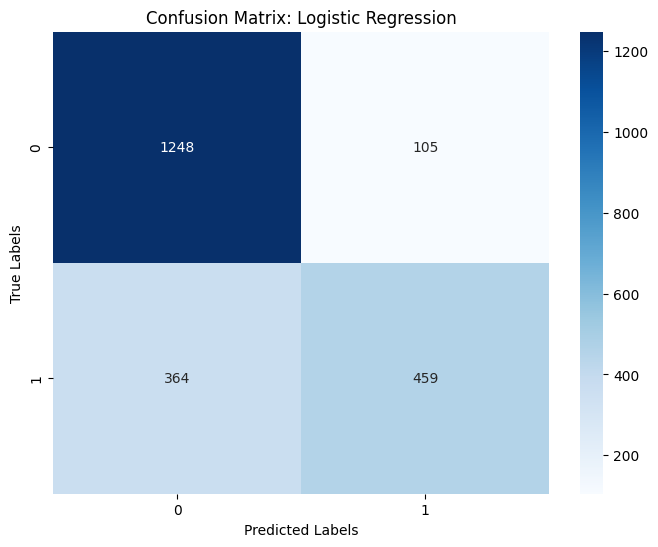

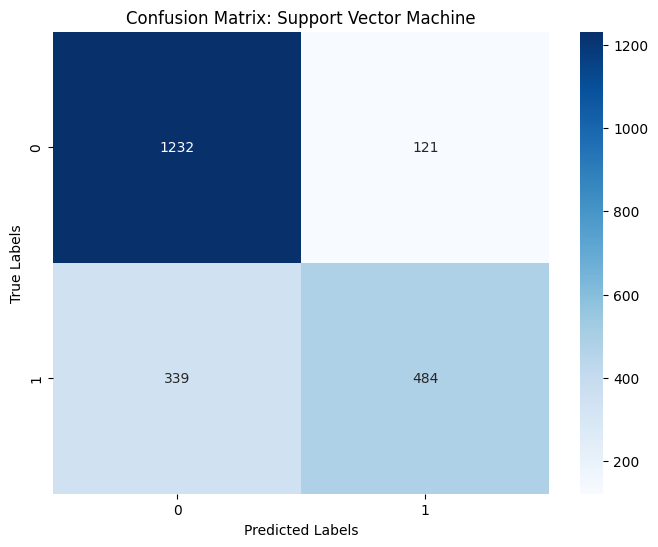

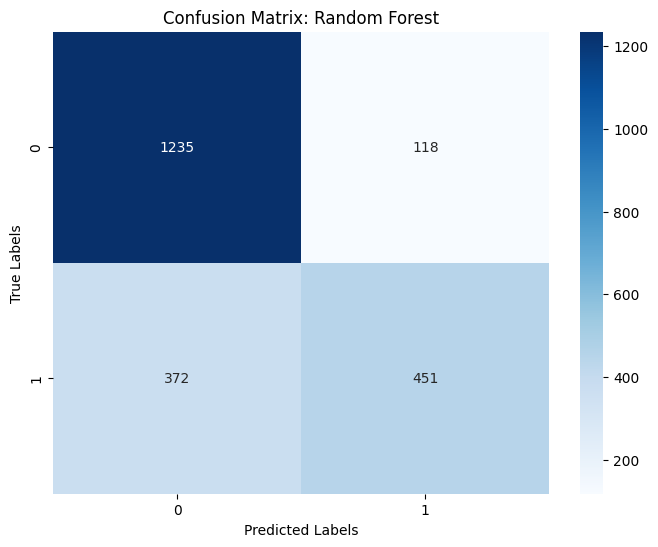

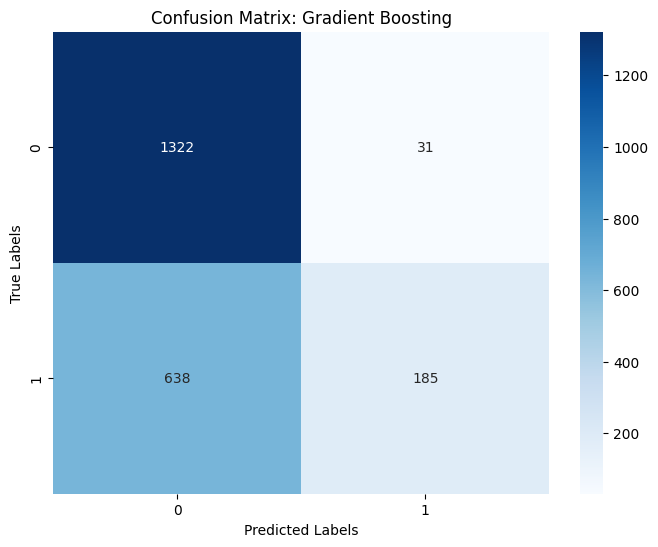

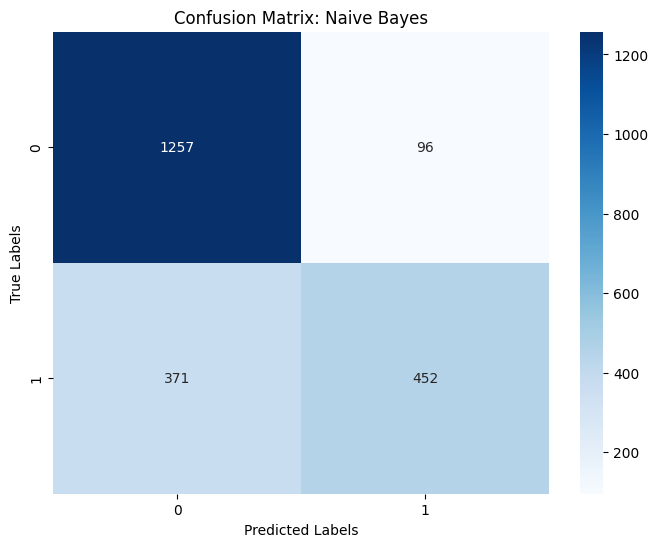

Logistic Regression - Accuracy: 0.7845, Precision: 0.7892, Recall: 0.7845, F1 Score: 0.7738
Support Vector Machine - Accuracy: 0.7886, Precision: 0.7902, Recall: 0.7886, F1 Score: 0.7803
Random Forest - Accuracy: 0.7748, Precision: 0.7776, Recall: 0.7748, F1 Score: 0.7639
Gradient Boosting - Accuracy: 0.6926, Precision: 0.7433, Recall: 0.6926, F1 Score: 0.6309
Naive Bayes - Accuracy: 0.7854, Precision: 0.7920, Recall: 0.7854, F1 Score: 0.7738


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

results = {}
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Printing results
for model, metrics in results.items():
    print(f"{model} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")